In [1]:
import os
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize, to_pil_image
import matplotlib.pyplot as plt
import json

parent_dir = os.path.abspath(os.path.pardir)
sys.path.append(parent_dir)

import datasets
from models import get_model
from utils import resize_density_map, sliding_window_predict

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

dataset_name = "qnrf"
split = "val"

truncation = 4
reduction = 8
granularity = "fine"
anchor_points = "average"

model_name = "clip_vit_b_16"
input_size = 224
window_size = 224
stride = 224
weight_count_loss = 1.0
count_loss = "dmcount"

# Comment the lines below to test non-CLIP models.
prompt_type = "word"
num_vpt = 32
vpt_drop = 0.
deep_vpt = True

/Users/yiming/mambaforge/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [2]:
if truncation is None:  # regression, no truncation.
    bins, anchor_points = None, None
else:
    with open(os.path.join(parent_dir, "configs", f"reduction_{reduction}.json"), "r") as f:
        config = json.load(f)[str(truncation)][dataset_name]
    bins = config["bins"][granularity]
    anchor_points = config["anchor_points"][granularity]["average"] if anchor_points == "average" else config["anchor_points"][granularity]["middle"]
    bins = [(float(b[0]), float(b[1])) for b in bins]
    anchor_points = [float(p) for p in anchor_points]

model = get_model(
    backbone=model_name,
    input_size=input_size, 
    reduction=reduction,
    bins=bins,
    anchor_points=anchor_points,
    # CLIP parameters
    prompt_type=prompt_type,
    num_vpt=num_vpt,
    vpt_drop=vpt_drop,
    deep_vpt=deep_vpt
)

ckpt_dir_name = f"{model_name}_{prompt_type}_" if "clip" in model_name else f"{model_name}_"
ckpt_dir_name += f"{input_size}_{reduction}_{truncation}_{granularity}_"
ckpt_dir_name += f"{weight_count_loss}_{count_loss}"

ckpt_path = os.path.join(
    parent_dir,
    "checkpoints",
    dataset_name,
    ckpt_dir_name,
    "best_mae_0.pth"  # select the weight file that you want to test
)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt)
model = model.to(device)

Missing keys: []
Unexpected keys: ['proj']
All keys matched successfully.
Initialized model with text prompts: ['There is no person.', 'There is one person.', 'There are two people.', 'There are three people.', 'There are more than four people.']


In [3]:
dataset = datasets.Crowd(dataset=dataset_name, split=split, sigma=8, return_filename=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=datasets.collate_fn)
data_iter = iter(dataloader)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
alpha = 0.8

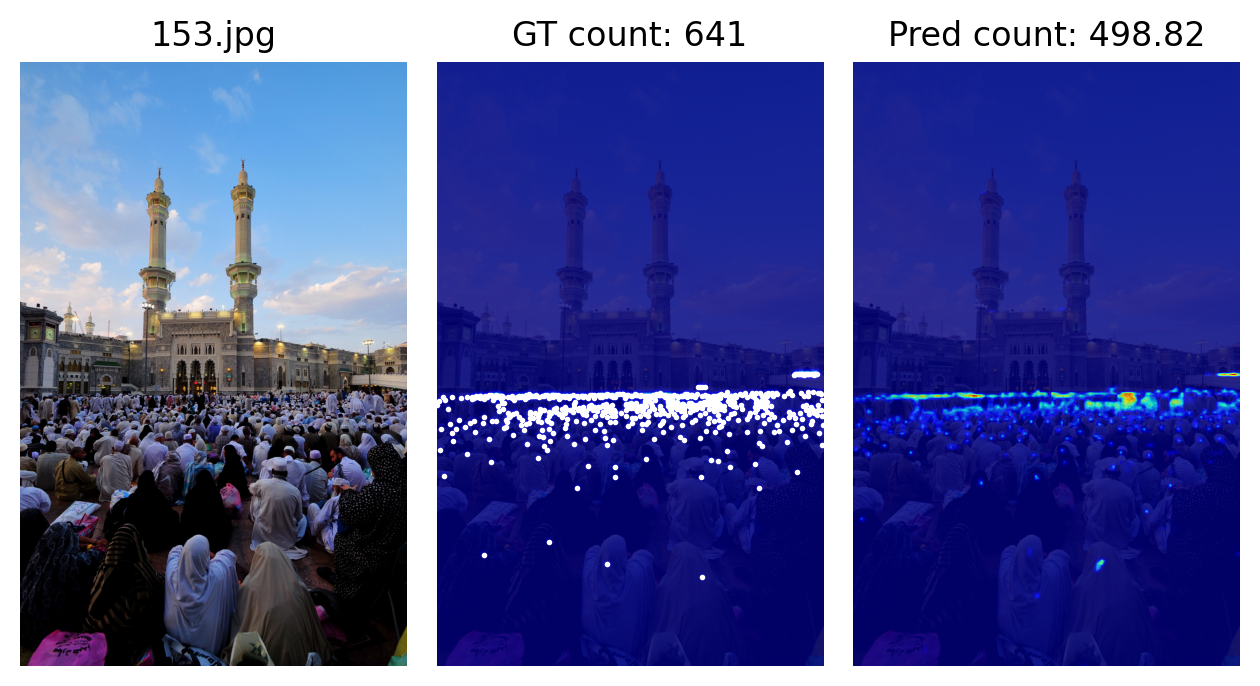

In [4]:
img_id = None
model.eval()
if img_id is not None:
    image, points, density, image_path = dataset[img_id]
else:
    image, points, density, image_path = next(data_iter)

image_height, image_width = image.shape[-2:]
image = image.to(device)
image_name = os.path.basename(image_path[0])

with torch.no_grad():
    if stride is not None:  # Sliding window prediction.
        pred_density = sliding_window_predict(model, image, window_size, stride)
    else:
        pred_density = model(image)
    pred_count = pred_density.sum().item()
    resized_pred_density = resize_density_map(pred_density, (image_height, image_width)).cpu()

image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0))

density = density.squeeze().numpy()
resized_pred_density = resized_pred_density.squeeze().numpy()
points = points[0].numpy()

fig, axes = plt.subplots(1, 3, dpi=200, tight_layout=True, frameon=False)
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title(f"{image_name}")

axes[1].imshow(image)
if len(points) > 0:
    axes[1].scatter(points[:, 0], points[:, 1], s=1, c="white")
    axes[1].imshow(density, cmap="jet", alpha=alpha)
axes[1].axis("off")
axes[1].set_title(f"GT count: {len(points)}")

axes[2].imshow(image)
axes[2].imshow(resized_pred_density, cmap="jet", alpha=alpha)
axes[2].axis("off")
axes[2].set_title(f"Pred count: {pred_count:.2f}")

plt.show()
# fig.savefig(f"output/{image_name}", transparent=True, bbox_inches="tight", pad_inches=0)